In [1]:
import numpy as np
import random

import os
import pickle
import sys
import timeit

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_spd_matrix
from sklearn.ensemble import RandomForestRegressor
from scipy.stats.stats import pearsonr 

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter

from matplotlib.pyplot import imshow
%matplotlib inline 

from IPython.display import Image 

from util import fit_IPTW_LR, fit_IPTW_RF, fit_IPTW_SVM
from util import sim_Data, sim_Unobs_Data, evaluation, bayes_unobs_confounder
import pickle

<img src="split_treatment.png" width="400"/>

## Generate data with no-unobs. confounding

Avg compliance: 0.9000000000000001
Fit IPTW + LR
p_A: 0.5519, IPTW: 1.00 +/- 0.07
Est. Y_0 RMSE: 0.006015343260168021
Est. Y_1 RMSE: 0.0036479393038186744
95.3% A matched Z, RMSE: 0.14
Fit IPTW + SVM
p_A: 0.5519, IPTW: 1.00 +/- 0.07
Est. Y_0 RMSE: 0.000447957189089653
Est. Y_1 RMSE: 0.05634187059819866
95.3% A matched Z, RMSE: 0.17


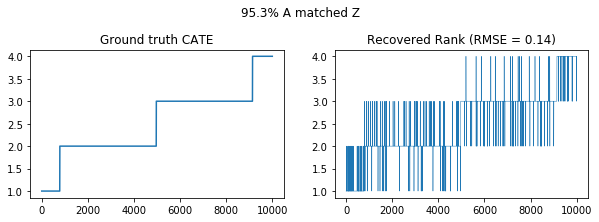

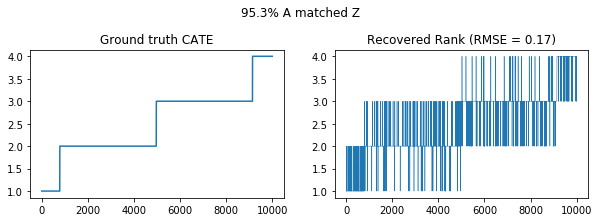

In [2]:
xDim = 50
nSim = 10000

p_AgivenZ = 1
p_AgivenNotZ = 0.1
        
X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)

print('Fit IPTW + LR')
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

print('Fit IPTW + SVM')
Yhat_0, Yhat_1 = fit_IPTW_SVM(X_data, Y_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

## Violation of Assumption 1: Generate data with unobs. confounding

Avg compliance: 0.9000000000000001
p_A: 0.5513, IPTW: 1.00 +/- 0.07
Est. Y_0 RMSE: 0.978256315944829
Est. Y_1 RMSE: 0.0022358877934539278
94.8% A matched Z, RMSE: 0.35


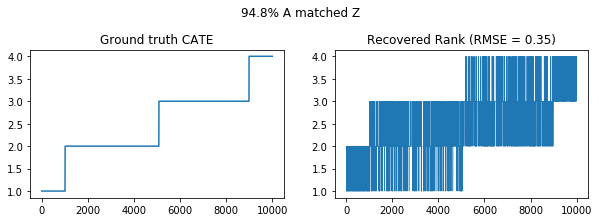

In [9]:
xDim = 50
nSim = 10000
p_AgivenZ = 1
p_AgivenNotZ = 0.1

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Unobs_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data,A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

## Violation of Assumption 2: Generate data violating the split-treatment criterion 

Avg compliance: -0.1
p_A: 0.6484, IPTW: 1.00 +/- 0.06
Est. Y_0 RMSE: 0.004216969520560497
Est. Y_1 RMSE: 0.4472061239601704
45.0% A matched Z, RMSE: 1.80


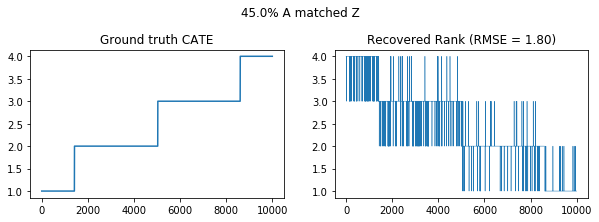

In [10]:
xDim = 50
nSim = 10000
p_AgivenZ = 0.6
p_AgivenNotZ = 0.7

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

# Refutation Analysis

### Generating Unobserved Confounders

In [ ]:
# Treatment: A_data; Features: X_data; Labels: Y_data [ Each of shape 10k*1 or 10k*50 ]
# A and A_data are the same

xDim = 50
nSim = 10000

A_matched_Z = []
RMSEs = []
A_matched_Z_unobs = []
RMSEs_unobs = []

corr_t=[]
corr_y=[]
counter=0
for p_AgivenZ in [0.6, 0.7, 0.8, 0.9, 1]:
    for p_AgivenNotZ in [0.5, 0.4, 0.3, 0.2, 0.1]:

        X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
        print(np.sum(Y_0_data), np.sum(Y_1_data))
        
        #Generate Obs Refutation Data
        alpha= 1000
        eps= 10*alpha
        corr_treat, corr_out, X_data_unobs= bayes_unobs_confounder(X_data, A_data, Y_data, alpha, eps)
        corr_t.append(corr_treat)
        corr_y.append(corr_out)
        
        #Results on Normal Data
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
        a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
        
        A_matched_Z.append(a_matched_z)
        RMSEs.append(rmse)
        
        #Results on Confounded Data
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data_unobs, Y_data, A_data, nObs)
        a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
        
        A_matched_Z_unobs.append(a_matched_z)
        RMSEs_unobs.append(rmse)
        
        
#         if counter ==0:
#             counter+=1
#             print(X_data.shape, Y_data.shape, A_data.shape, Group_data.shape, Y_0_data.shape, Y_1_data.shape)
#             print(Y_data[0], Y_0_data[0], Y_1_data[0], A[0])
#             print(Y_data[10], Y_0_data[10], Y_1_data[10], A[10])
#             print(A_data)
#             print(A, Z, nObs, len(A), len(Z))
            
#             if np.array_equal(A, A_data):
#                 print('Yes')
                
#             if np.array_equal(X_data, Group_data):
#                 print('Yes')
#             else:
#                 print('No')

corr_t=np.array(corr_t)
corr_y=np.array(corr_y)

print('Final')
print('Correlation Treatment: ', np.mean(corr_t), np.std(corr_t))
print('Correlation Outcome: ', np.mean(corr_y), np.std(corr_y))

### Results with True Data

In [ ]:
A_matched_Z = np.array(A_matched_Z)
RMSEs = np.array(RMSEs)
sort_indice = np.argsort(A_matched_Z)
plt.plot(A_matched_Z[sort_indice], RMSEs[sort_indice])
plt.xlabel('% of A matched Z')
plt.ylabel('RMSE')

### Results with Unobs Confounding

In [ ]:
A_matched_Z_unobs = np.array(A_matched_Z_unobs)
RMSEs_unobs = np.array(RMSEs_unobs)
sort_indice = np.argsort(A_matched_Z_unobs)
plt.plot(A_matched_Z_unobs[sort_indice], RMSEs_unobs[sort_indice])
plt.xlabel('% of A matched Z')
plt.ylabel('RMSE')

### Sweep over Unobs Confounders

Avg compliance: 0.5999999999999999
962.1969069217182 827895.5302402548
p_A: 0.4977, IPTW: 1.00 +/- 0.07
Est. Y_0 RMSE: 0.015520559524753412
Est. Y_1 RMSE: 0.25704601171000313
79.2% A matched Z, RMSE: 0.19
% of A matched Z 0.792


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4977, IPTW: 1.00 +/- 0.90
Est. Y_0 RMSE: 0.02314345253048608
Est. Y_1 RMSE: 0.03465128716427189
79.2% A matched Z, RMSE: 0.22
Final
Correlation Treatment:  0.510755205211761
Correlation Outcome:  0.42495846380107727


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


p_A: 0.4977, IPTW: 1.00 +/- 0.53
Est. Y_0 RMSE: 0.0074217029289097665
Est. Y_1 RMSE: 0.08232692524511485
79.2% A matched Z, RMSE: 0.20
Final
Correlation Treatment:  0.3899621144676216
Correlation Outcome:  0.32718489718378063
p_A: 0.4977, IPTW: 1.00 +/- 0.15


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Est. Y_0 RMSE: 0.011973616970199302
Est. Y_1 RMSE: 0.2607153225343094
79.2% A matched Z, RMSE: 0.19
Final
Correlation Treatment:  0.12346334646524929
Correlation Outcome:  0.09259920542941028


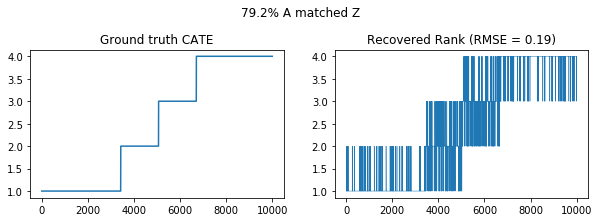

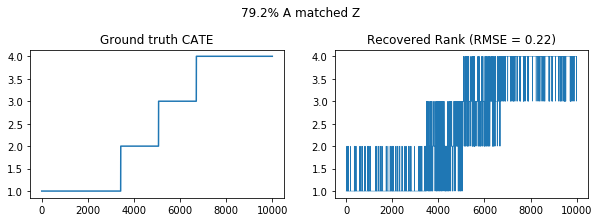

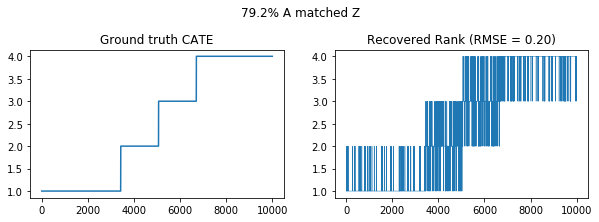

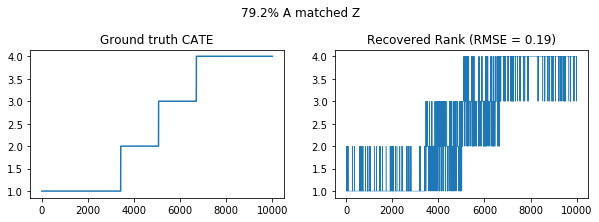

In [13]:
# Treatment: A_data; Features: X_data; Labels: Y_data [ Each of shape 10k*1 or 10k*50 ]
# A and A_data are the same

xDim = 50
nSim = 10000

#Data Generation
A_matched_Z = []
RMSEs = []

# A percentage Z match 52% params
# p_AgivenZ= 0.6
# p_AgivenNotZ=0.5

# A percentage Z match 77% params
p_AgivenZ= 0.8
p_AgivenNotZ=0.2

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
print(np.sum(Y_0_data), np.sum(Y_1_data))

#Results on Normal Data
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, Y_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
print('% of A matched Z', a_matched_z)

A_matched_Z.append(a_matched_z)
RMSEs.append(rmse)

#UnObs Confounder
A_matched_Z_unobs = []
RMSEs_unobs = []

corr_t=[]
corr_y=[]
alpha_range= [10**3, 10**4, 10**5]

for alpha in alpha_range:

    #Generate Obs Refutation Data
    eps= 5000*alpha
    if alpha ==10**3:
        eps=5*eps
    
    corr_treat, corr_out, X_data_unobs= bayes_unobs_confounder(X_data, A_data, Y_data, alpha, eps)
    corr_t.append(corr_treat)
    corr_y.append(corr_out)

    #Results on Confounded Data
    Yhat_0, Yhat_1 = fit_IPTW_LR(X_data_unobs,Y_data,  A_data, nObs)
    a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

    A_matched_Z_unobs.append(a_matched_z)
    RMSEs_unobs.append(rmse)

    print('Final')
    print('Correlation Treatment: ', corr_treat)
    print('Correlation Outcome: ', corr_out)
    
alpha_range=np.array(alpha_range)
alpha_range=10000*(1/alpha_range)

[2 1 0] [0.21540659 0.19595918 0.18920888]


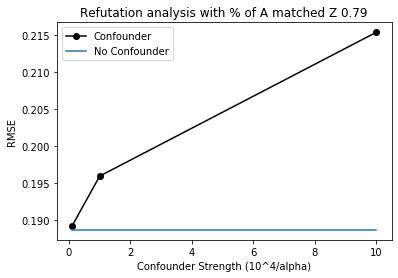

In [15]:
A_matched_Z_unobs = np.array(A_matched_Z_unobs)
RMSEs_unobs = np.array(RMSEs_unobs)

sort_indice = np.argsort(A_matched_Z_unobs)
sort_indice = sort_indice[::-1]
print(sort_indice, RMSEs_unobs)

plt.plot(alpha_range[sort_indice], RMSEs_unobs[sort_indice], '-ok', label='Confounder')
plt.plot(alpha_range[sort_indice], len(alpha_range)*RMSEs, label='No Confounder')
plt.xlabel('Confounder Strength (10^4/alpha)')
plt.ylabel('RMSE')
plt.title('Refutation analysis with % of A matched Z ' + str(np.round(a_matched_z,2)))
plt.legend()
#plt.savefig('images/a_52.jpg')

Text(0.5, 1.0, 'Correlation of Confounder with Treatment A')

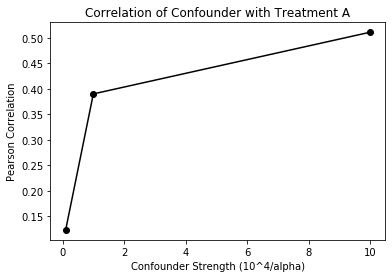

In [16]:
plt.plot(alpha_range, corr_t, '-ok')
plt.xlabel('Confounder Strength (10^4/alpha)')
plt.ylabel('Pearson Correlation')
plt.title('Correlation of Confounder with Treatment A')
#plt.savefig('images/b_52.jpg')

Text(0.5, 1.0, 'Correlation of Confounder with Outcome Y')

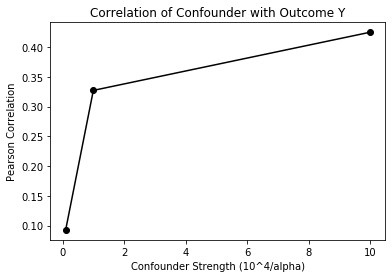

In [17]:
plt.plot(alpha_range, corr_y, '-ok')
plt.xlabel('Confounder Strength (10^4/alpha)')
plt.ylabel('Pearson Correlation')
plt.title('Correlation of Confounder with Outcome Y')
#plt.savefig('images/c_52.jpg')